In [1]:
import matplotlib.pyplot as plt  
import re, string, unicodedata                          
import numpy as np                                      
import pandas as pd                                     
import nltk                           

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer            

nltk.download('stopwords')                           
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# raw_raw = pd.read_csv('local_files/raw_scraping.csv', encoding='utf-8')
# raw_data = raw_raw[['GOAL_CATEGORY_NAME', 'NAME']].copy()
# raw_data = raw_data.rename(columns={'GOAL_CATEGORY_NAME': 'category', 'NAME': 'name'})
# raw_data.to_csv('files/scraping_rf_v1.csv', index=False, encoding='utf-8')

In [5]:
raw_data = pd.read_csv('files/scraping_rf_v1.csv', encoding='utf-8')
raw_data['category'].value_counts()

category
Plomería                 773
Herramientas             397
Electricos               315
Ferretería               154
Aseo, Baños y Cocinas    117
Pinturas                  59
Name: count, dtype: int64

## Clean the product name

In [ ]:
stop_words = set(stopwords.words('spanish')).union(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    
    words = re.split(r'\s+', text) 
    words = [word for word in words if word not in stop_words and len(word) >= 3]
    words = [lemmatizer.lemmatize(word) for word in words]  # Lematizar palabras
    return words


word_freq_by_cat = {}

raw_data['processed_name'] = (raw_data['name'].apply(lambda x: preprocess_text(x))).copy(deep=True)
raw_data.head(5)

# %%
def turn_into_strings(words):
    return ' '.join(words)

raw_data['clean_name'] = raw_data['processed_name'].apply(lambda x: turn_into_strings(x))
# raw_data.head(5)

# %%
df_co = raw_data[['category', 'clean_name']].copy()

# Building the model based on CountVectorizer and Random Forest

In [7]:
bow_vec = CountVectorizer(max_features=2000)                
data_features = bow_vec.fit_transform(df_co['clean_name'])

data_features = data_features.toarray()
data_features.shape

# %%
all_labels = df_co['category'].copy(deep=True)
all_labels = all_labels.tolist()
len(all_labels)

1815

In [ ]:
# Create a dictionary mapping unique categories to numerical values
category_mapping = {category: idx for idx, category in enumerate(set(all_labels))}

# Convert categories into numerical variables
numerical_labels = [category_mapping[label] for label in all_labels]

# Display the mapping and a sample of numerical labels
print(category_mapping)
print(numerical_labels[:10])

## Train the model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_features, all_labels, test_size=0.3, random_state=42)

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, all_labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7982605791998058


## Cross validation

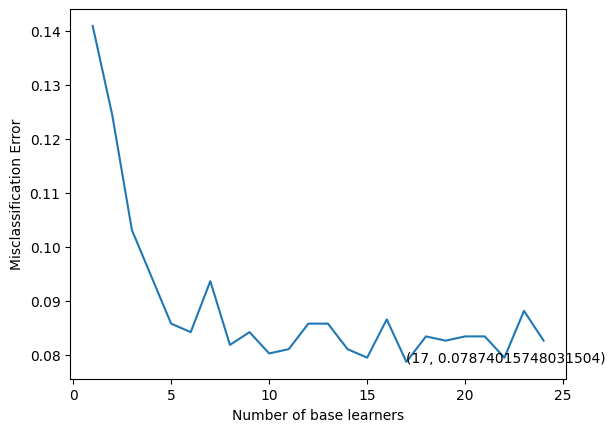

In [14]:
base_ln = [x for x in range(1, 25)]
base_ln

cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())


error = [1 - x for x in cv_scores]                                 
optimal_learners = base_ln[error.index(min(error))]                
plt.plot(base_ln, error)                                          
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

## re-train using the optimal number of learners

In [16]:
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9376146788990826

In [17]:
result =  clf.predict(X_test)   
conf_mat = confusion_matrix(y_test, result)
conf_mat

array([[ 29,   0,   0,  13,   0,   0],
       [  0,  89,   0,   4,   1,   0],
       [  0,   0,  26,   8,   0,   1],
       [  0,   1,   1, 125,   0,   1],
       [  0,   0,   0,   0,  15,   0],
       [  0,   0,   0,   4,   0, 227]])

## Testing the model

In [18]:
test_str = ["taladro", 'foco led', 'tubo pvc', 'cinta de embalaje']

# Vectorize the new string using the already fitted vectorizer
test_features = bow_vec.transform(test_str)

# If you need it as an array
test_features = test_features.toarray()

# Predict the category using the trained model
predicted_category = clf.predict(test_features)
predicted_category



array(['Herramientas', 'Electricos', 'Plomería', 'Ferretería'],
      dtype='<U21')